In [25]:
from pathlib import Path

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Load reference data

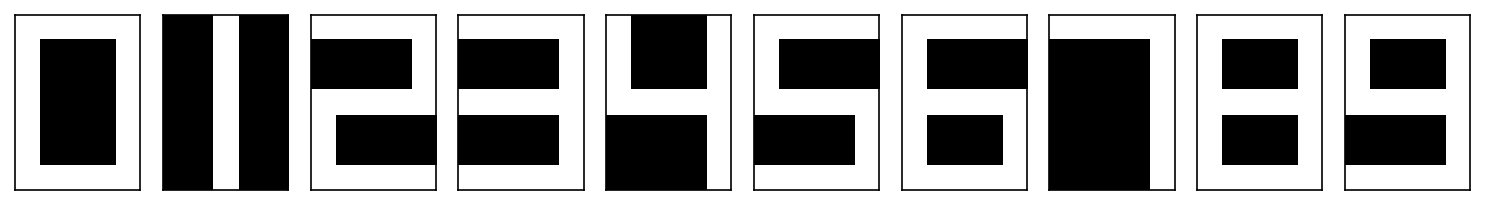

In [26]:
img_shape = (7, 5)
img_size = 35

data_path = Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [27]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [28]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [29]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define model

In [30]:
@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, w: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        y = softmax(w @ x_batch[i] + b)
        dLdy = y - y_batch[i]
        dw += np.outer(dLdy, x_batch[i])
        db += dLdy

    return (dw, db)


class Perceptron:
    def __init__(self, n_in: int, n_out: int) -> None:
        self.n_in = n_in
        self.n_out = n_out
        self.w: np.ndarray = np.random.uniform(-1, 1, (n_out, n_in))
        self.b: np.ndarray = np.zeros(n_out)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return softmax(self.w @ x + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dw, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.w, self.b)

                self.w -= lr * dw
                self.b -= lr * db

### Create and train model

In [31]:
n_in = 35
n_out = 10

learning_rate = 1e-1
batch_size = 8
max_epoch = 100

model = Perceptron(n_in, n_out)

print('untrained loss: ', model.loss(x_test, y_test).round(4))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(4))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.4854
trained loss:  0.001
test set accuracy: 100.0%


### Test model on big number of noised samples

In [41]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 95.41%


### Visualize model predictions

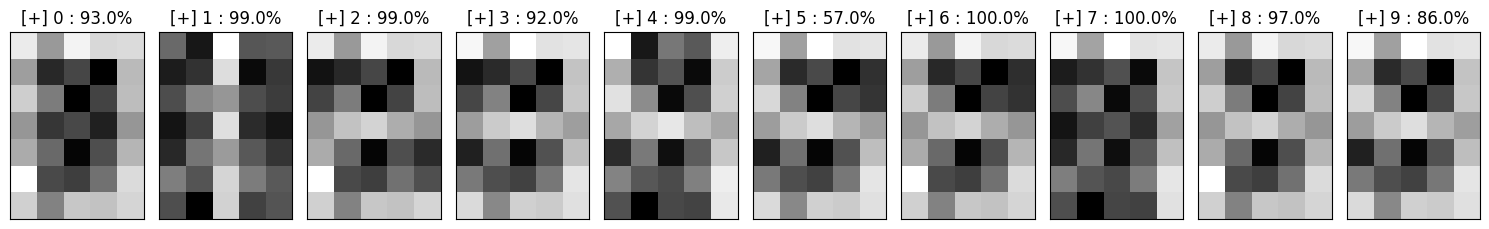

In [40]:
noise_size = 1.0

x_noised = data_mtrx + np.random.uniform(0.0, noise_size, img_size)
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"[{'+' if j == i else '-'}] {j} : {(y[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()